In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator
import os

import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################


num_classes = 20
img_rows, img_cols = 32, 32
batch_size = 16

train_data_dir = './simpsons/train'
validation_data_dir = './simpsons/validation'

# Let's use some data augmentaiton \n",
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Using TensorFlow backend.


Found 19548 images belonging to 20 classes.
Found 990 images belonging to 20 classes.


In [2]:
model = Sequential()

# First CONV-ReLU Layer\n",
model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Second CONV-ReLU Layer\n",
model.add(Conv2D(64, (3, 3), padding = "same", input_shape = (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout \n",
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers\n",
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers\n",
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout \n",
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers\n",
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers\n",
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout \n",
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# First set of FC or Dense Layers\n",
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second set of FC or Dense Layers\n",
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Dense Layer\n",
model.add(Dense(num_classes))
model.add(Activation("softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

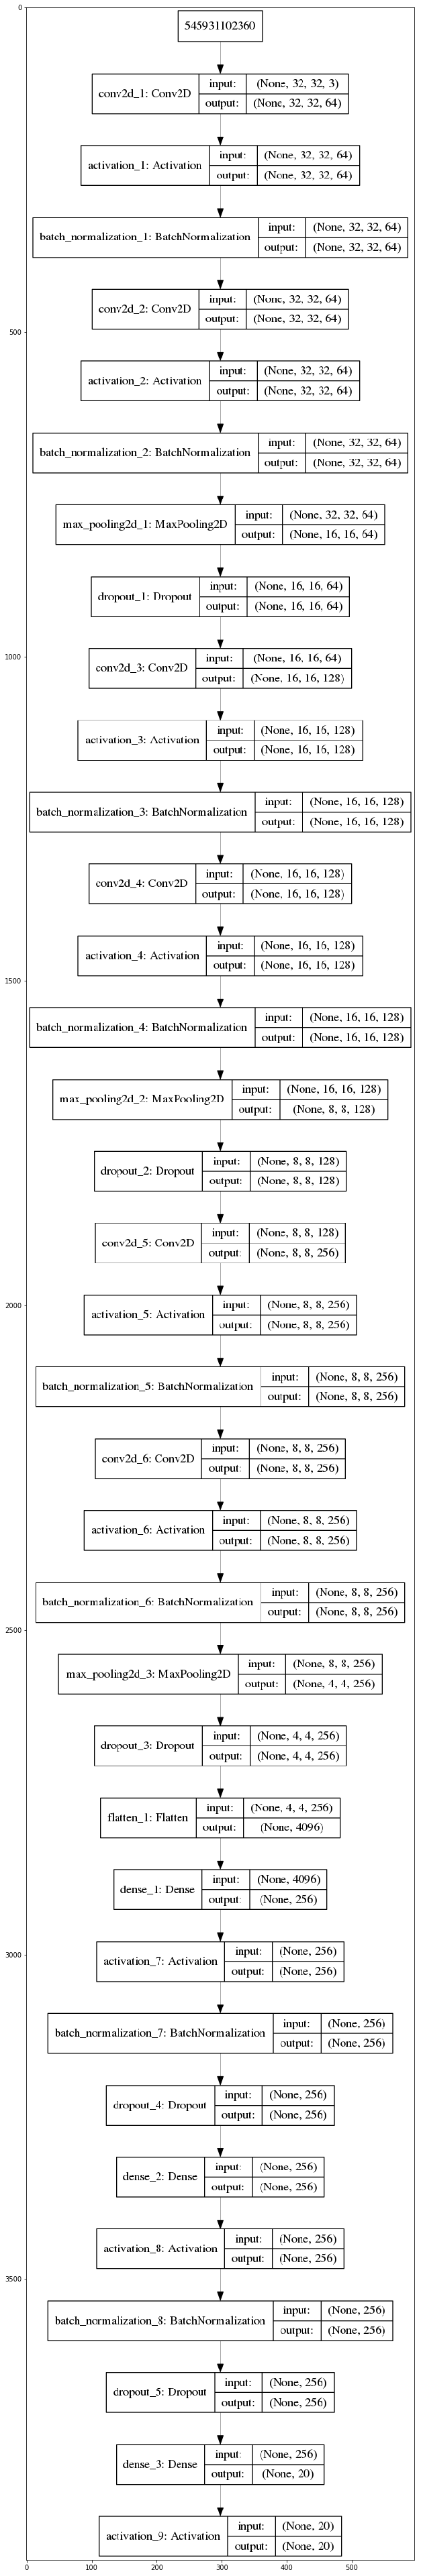

In [3]:
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

plot_model(model, to_file='LittleVGG.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('LittleVGG.png')
plt.figure(figsize=(100,70))
imgplot = plt.imshow(img) 

In [4]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./Trained Models/simpsons_little_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

# we put our call backs into a callback list\n",
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate \n",
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy'])

nb_train_samples = 19548
nb_validation_samples = 990
epochs = 10

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
1221/1221 [==============================] - 255s 209ms/step - loss: 2.8665 - acc: 0.1557 - val_loss: 2.5971 - val_acc: 0.2623

Epoch 00001: val_loss improved from inf to 2.59712, saving model to ./Trained Models/simpsons_little_vgg.h5
Epoch 2/10
1221/1221 [==============================] - 202s 166ms/step - loss: 2.3245 - acc: 0.2848 - val_loss: 3.7899 - val_acc: 0.1530

Epoch 00002: val_loss did not improve from 2.59712
Epoch 3/10
1221/1221 [==============================] - 203s 166ms/step - loss: 2.0654 - acc: 0.3718 - val_loss: 2.1562 - val_acc: 0.3060

Epoch 00003: val_loss improved from 2.59712 to 2.15618, saving model to ./Trained Models/simpsons_little_vgg.h5
Epoch 4/10
1221/1221 [==============================] - 202s 165ms/step - loss: 1.7527 - acc: 0.4745 - val_loss: 1.4109 - val_acc: 0.5688

Epoch 00004: val_loss improved from 2.15618 to 1.41092, saving model to ./Trained Models/simpsons_little_vgg.h5
Epoch 5/10
1221/1221 [==============================] - 202s 

Found 990 images belonging to 20 classes.
Confusion Matrix
[[35  0  0  0  0  0  0  9  0  0  2  0  0  0  0  0  2  0  0  0]
 [ 0 49  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 38  1  0  0  0  6  0  0  2  2  0  0  0  0  0  0  0  0]
 [ 0  0  0 30  2  0  2  8  0  1  0  1  0  0  2  0  2  0  0  0]
 [ 0  0  0  0 45  0  0  0  0  1  0  0  0  0  0  4  0  0  0  0]
 [ 3  0  0  0  1 35  0  0  0  3  0  0  1  1  0  0  3  0  2  0]
 [ 0  0  0  0  0  0 41  0  0  2  0  0  1  0  0  0  6  0  0  0]
 [ 1  0  0  0  0  0  0 49  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  4 37  2  0  2  1  0  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 45  0  0  0  0  0  4  0  0  0]
 [ 1  0 10  1  1  0  0  6  0  0  0 28  0  1  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 49  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0  2  0  0 42  0  1  2  1  0  0]
 [ 0  0  0  0  1  0  1  0  0  1  0  0  0  0 45  0  1  0  0 

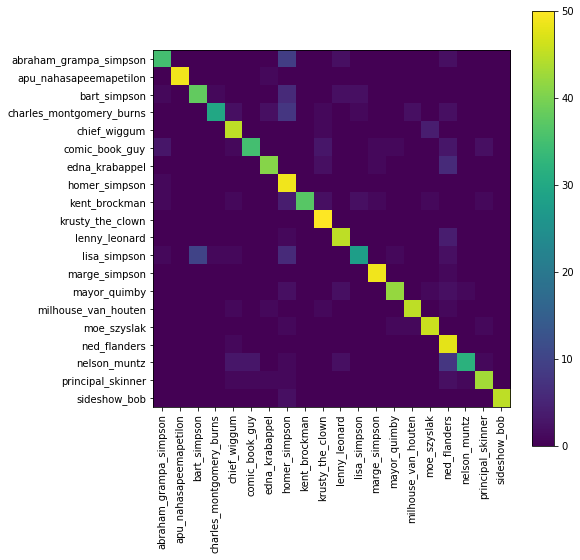

In [6]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false\n",
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 19548
nb_validation_samples = 990

#Confution Matrix and Classification Report\n",
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [8]:
from keras.models import load_model

# 77% Accuracy after just 10 Epochs\n",
classifier = load_model('./Trained Models/simpsons_little_vgg.h5')


In [9]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images\n",
img_width, img_height = 32, 32

files = []
predictions = []
true_labels = []

# predicting images\n",
for i in range(0, 10):
    path = './simpsons/validation/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = classifier.predict_classes(images, batch_size = 10)
    predictions.append(classes)

for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=5, fy=5, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()